In [2]:
import sys
import os
import torch.multiprocessing as mp
from auv_control.parallel_train import parallel_train

print(sys.path)
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation
import seaborn as sns
import numpy as np
import holoocean
from tqdm import tqdm

from auv_control.estimation import InEKF
from auv_control.control import LQR
from auv_control.planning.LQR_SAC import LQRSACPlanner
from auv_control.planning.Dijkstras import Dijkstra
from auv_control.planning.astar import Astar
from auv_control.planning.aco_astar import ACO_AStar
from auv_control.planning import Traj, RRT
from auv_control import State
from plotter import Plotter
from auv_control import scenario
sns.set(context="paper", style="whitegrid", font_scale=0.8)

from mpl_toolkits.mplot3d import Axes3D

class Plotter:
    def __init__(self, names):
        # Where all the data is stored
        self.t = []
        self.data = None

        self.num_row = 5
        self.num_col = 3
        self.num_items = len(names)

        # Setup figure
        self.fig, self.ax = plt.subplots(
            self.num_row, self.num_col, figsize=(6, 8), sharex=True
        )

        # Setup all lines
        self.lines = [[[] for _ in range(self.num_row)] for _ in range(len(names))]
        for i in range(self.num_row):
            for j in range(self.num_col):
                for k, n in enumerate(names):
                    (p,) = self.ax[i, j].plot([], [], label=n)
                    self.lines[k][i].append(p)

        self.ax[-1, 2].legend()

        # Add axes labels
        titles = ["Position", "Velocity", "RPY", "Bias - Omega", "Bias - Acceleration"]
        for i in range(self.num_row):
            self.ax[i, 1].set_title(titles[i])
        self.fig.tight_layout()
        plt.savefig("layout.png")
        
        plt.ion()
        # Additional setup for 3D plot
        self.fig_3d = plt.figure(figsize=(8, 6))
        self.ax_3d = self.fig_3d.add_subplot(111, projection='3d')
        self.ax_3d.set_title("AUV 3D Trajectory")
        self.ax_3d.set_xlabel("X Position (m)")
        self.ax_3d.set_ylabel("Y Position (m)")
        self.ax_3d.set_zlabel("Z Position (m)")

    def add_timestep(self, t, states):
        # Keep the time
        self.t.append(t)

        # Plop our data at the end of the other data
        new_state = np.stack([s.data_plot for s in states])

        if self.data is None:
            # Initialize self.data if it hasn't been initialized yet
            self.data = new_state[:, :, np.newaxis]
        else:
            # Concatenate new data along the third axis
            self.data = np.concatenate((self.data, new_state[:, :, np.newaxis]), axis=2)

    def _rot_to_rpy(self, mat):
        return Rotation.from_matrix(mat).as_euler("xyz")

    def update_plots(self):
        # Update all lines
        for i in range(self.num_row):
            for j in range(self.num_col):
                for k in range(self.num_items):
                    # Ensure that the data is correctly indexed to provide a sequence
                    if self.num_col * i + j < self.data.shape[1]:
                        y_data = self.data[k, self.num_col * i + j, :]
                        # Check if y_data length matches the length of t
                        if len(self.t) == y_data.shape[0] and not (np.any(np.isnan(y_data)) or np.any(np.isinf(y_data))):
                            self.lines[k][i][j].set_data(self.t, y_data)

                self.ax[i, j].relim()
                self.ax[i, j].autoscale_view()

        # Update 3D trajectory plot
        for k in range(self.num_items):
            x_data = self.data[k, 0, :]  # X positions
            y_data = self.data[k, 1, :]  # Y positions
            z_data = self.data[k, 2, :]  # Z positions (height)
            if len(self.t) == x_data.shape[0]:
                self.ax_3d.plot(x_data, y_data, z_data, label=f"{k}-{self.lines[k][0][0].get_label()}")
            
            # Plot start and end points
            if k == 0 and len(x_data) > 0:
                self.ax_3d.scatter(
                    x_data[0], y_data[0], z_data[0], c='green', marker='o', s=100, label=f"{self.lines[k][0][0].get_label()} Start" if k == 0 else None
                )
                self.ax_3d.scatter(
                    x_data[-1], y_data[-1], z_data[-1], c='red', marker='x', s=100, label=f"{self.lines[k][0][0].get_label()} End" if k == 0 else None
                )

        self.ax_3d.legend()

        # Display the updated plot in Jupyter
        plt.show()
        print("Plot updated in Jupyter Notebook.")

# Main function to run the simulation
def main(num_seconds=100, show=False, plot=True, verbose=False, route="rrt", num_workers=10, num_episodes=200,ctrain = False,max_step = 1000,model_path=""):
    if "Ocean" not in holoocean.installed_packages():
        holoocean.install("Ocean")

    # Load in HoloOcean info
    ts = 1 / scenario["ticks_per_sec"]
    num_ticks = int(num_seconds / ts)

    # Set everything up
    controller = LQR()
    observer = InEKF()
    dummy_env = holoocean.make(scenario_cfg=scenario, show_viewport=False, verbose=verbose)
    if route == "rrt":
        planner = RRT(num_seconds)
        print("this RRT way")
    elif route == "astar":
        planner = Astar(num_seconds)
        print("this Astar way")
    elif route == "djs":
        planner = Dijkstra(num_seconds)
        print("this Dijkstra way")
    elif route == "aco":
        planner = ACO_AStar(num_seconds)
        print("this ACO_AStar way")
    elif route == "sac":
        planner = LQRSACPlanner(num_seconds)
        print("Using PPO planner")
        
        
        if not os.path.exists(model_path):
            planner.train(dummy_env, num_episodes=num_episodes, max_steps = max_step, model_path = model_path)
        elif ctrain:
            planner.load_model(model_path)
            new_path = 'ctrain_'+ model_path
            planner.train(dummy_env, num_episodes=num_episodes,max_steps = max_step, model_path = new_path)
            #parallel_train(planner, num_episodes, num_workers, verbose,scenario)

    else:
        planner = Traj(route, num_seconds)
        print("this way")
    if plot:
        plotter = Plotter(["True", "Estimated", "Desired"])

    # Run simulation!
    u = np.zeros(8)
    des_action = np.zeros(8)
    env = dummy_env
    env.set_render_quality(0)
    env.reset()
    if route == "sac":
        planner.load_model(model_path)  # 加载模型
        planner.setup_obstacles()
        planner.draw_traj(env, num_seconds)
        env.act("auv0", u)
        done = False
        sensors = env.tick()
        # Pluck true state from sensors
        t = sensors["t"]
        for i in tqdm(range(num_ticks)):
            true_state = State(sensors)
            d_g, d_n_o = planner.extract_element(true_state)
            if d_g < 5:
                done = True
            true_state_for_planner = np.append(true_state.vec[0:], true_state.bias[0:])
            #true_state_for_planner = np.append(true_state_for_planner, true_state.mat[0:])
            true_state_for_planner = np.append(true_state_for_planner, d_g)
            true_state_for_planner = np.append(true_state_for_planner, d_n_o)
            true_state_for_planner = np.append(true_state_for_planner, done)
            #real_next_state = State(real_next_state)
            # Estimate State
            est_state = observer.tick(sensors, ts)

            # Path planner

            des_action = planner.select_action(true_state_for_planner,inference = True)
            env.act("auv0", des_action)
            sensors = env.tick()

            # Pluck true state from sensors
            t = sensors["t"]
            des_state = State(sensors)
            # Autopilot Commands
            u = controller.u(est_state, des_state)
            # Update visualization
            if plot:
                plotter.add_timestep(t, [true_state, est_state, des_state])
            if done:
                break                
    else:
        for i in tqdm(range(num_ticks)):
            # Tick environment
            env.act("auv0", u)
            sensors = env.tick()

            # Pluck true state from sensors
            t = sensors["t"]
            true_state = State(sensors)

            # Estimate State
            est_state = observer.tick(sensors, ts)

            # Path planner

            des_state = planner.tick(t)

            # Autopilot Commands
            u = controller.u(est_state, des_state)
            #print(u)
            # Update visualization
            if plot:
                plotter.add_timestep(t, [true_state, est_state, des_state])

    # Final plot update after all data is collected
    if plot:
        plotter.update_plots()





['/sciclone/home/dyang06/DecisionMK/AUVControl', '/sciclone/home/dyang06/anaconda3/envs/Path/lib/python39.zip', '/sciclone/home/dyang06/anaconda3/envs/Path/lib/python3.9', '/sciclone/home/dyang06/anaconda3/envs/Path/lib/python3.9/lib-dynload', '', '/sciclone/home/dyang06/anaconda3/envs/Path/lib/python3.9/site-packages', '/sciclone/home/dyang06/anaconda3/envs/Path/lib/python3.9/site-packages/setuptools/_vendor']


In [ ]:
if __name__ == "__main__":
    #mp.set_start_method('spawn')  # 为多进程设置启动方法
    main(num_seconds=400, show=False, plot=True, verbose=False, route="sac", num_workers=1, num_episodes=1000,ctrain = False, max_step = 1024, model_path = 'SAC_r10_lre4_1024_best_model.pth')
    print("separated space \n")

Using PPO planner


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: diyang_uestc (diyang_uestc-william-mary). Use `wandb login --relogin` to force relogin


Episode 1 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


/sciclone/home/dyang06/DecisionMK/AUVControl/auv_control/planning/LQR_SAC.py:199: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.FloatTensor(transitions[0]).to(device)
Episode 1 completed - Total Reward: -2688.8269626885935
Model saved at episode 1 to SAC_r10_lre4_1024_best_model.pth
Episode 2 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 2 completed - Total Reward: -2215.431049232842
Model saved at episode 2 to SAC_r10_lre4_1024_best_model.pth
Episode 3 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 3 completed - Total Reward: -2379.6491265062286
Model saved at episode 3 to SAC_r10_lre4_1024_best_model.pth
Episode 4 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 4 completed - Total Reward: -2634.5288937590785
Model saved at episode 4 to SAC_r10_lre4_1024_best_model.pth
Episode 5 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 5 completed - Total Reward: -3157.371098775844
Model saved at episode 5 to SAC_r10_lre4_1024_best_model.pth
Episode 6 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 6 completed - Total Reward: -3377.6189473321815
Model saved at episode 6 to SAC_r10_lre4_1024_best_model.pth
Episode 7 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 7 completed - Total Reward: -3775.028533296206
Model saved at episode 7 to SAC_r10_lre4_1024_best_model.pth
Episode 8 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 8 completed - Total Reward: -2597.3469665262696
Model saved at episode 8 to SAC_r10_lre4_1024_best_model.pth
Episode 9 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 9 completed - Total Reward: -2766.0801115457475
Model saved at episode 9 to SAC_r10_lre4_1024_best_model.pth
Episode 10 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 10 completed - Total Reward: -2011.251750844084
Model saved at episode 10 to SAC_r10_lre4_1024_best_model.pth
Episode 11 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 11 completed - Total Reward: -3163.4547799005754
Model saved at episode 11 to SAC_r10_lre4_1024_best_model.pth
Episode 12 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 12 completed - Total Reward: -3733.7695471549173
Model saved at episode 12 to SAC_r10_lre4_1024_best_model.pth
Episode 13 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 13 completed - Total Reward: -2941.7421415439353
Model saved at episode 13 to SAC_r10_lre4_1024_best_model.pth
Episode 14 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 14 completed - Total Reward: -939.9125253769848
Model saved at episode 14 to SAC_r10_lre4_1024_best_model.pth
Episode 15 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 15 completed - Total Reward: -2027.3692052508077
Model saved at episode 15 to SAC_r10_lre4_1024_best_model.pth
Episode 16 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 16 completed - Total Reward: -2253.2442677114536
Model saved at episode 16 to SAC_r10_lre4_1024_best_model.pth
Episode 17 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 17 completed - Total Reward: -3070.4502968799866
Model saved at episode 17 to SAC_r10_lre4_1024_best_model.pth
Episode 18 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 18 completed - Total Reward: -2070.8611789263546
Model saved at episode 18 to SAC_r10_lre4_1024_best_model.pth
Episode 19 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 19 completed - Total Reward: -3794.494875838576
Model saved at episode 19 to SAC_r10_lre4_1024_best_model.pth
Episode 20 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 20 completed - Total Reward: -4249.257323204662
Model saved at episode 20 to SAC_r10_lre4_1024_best_model.pth
Episode 21 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 21 completed - Total Reward: -4125.891133006562
Model saved at episode 21 to SAC_r10_lre4_1024_best_model.pth
Episode 22 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 22 completed - Total Reward: -4279.223076179412
Model saved at episode 22 to SAC_r10_lre4_1024_best_model.pth
Episode 23 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 23 completed - Total Reward: -4439.101240895881
Model saved at episode 23 to SAC_r10_lre4_1024_best_model.pth
Episode 24 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 24 completed - Total Reward: -4507.860334685286
Model saved at episode 24 to SAC_r10_lre4_1024_best_model.pth
Episode 25 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 25 completed - Total Reward: -4059.8889304240492
Model saved at episode 25 to SAC_r10_lre4_1024_best_model.pth
Episode 26 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 26 completed - Total Reward: -813.4467857548553
Model saved at episode 26 to SAC_r10_lre4_1024_best_model.pth
Episode 27 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 27 completed - Total Reward: -1947.9030924388762
Model saved at episode 27 to SAC_r10_lre4_1024_best_model.pth
Episode 28 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 28 completed - Total Reward: -2646.909123700972
Model saved at episode 28 to SAC_r10_lre4_1024_best_model.pth
Episode 29 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 29 completed - Total Reward: -3008.033676345073
Model saved at episode 29 to SAC_r10_lre4_1024_best_model.pth
Episode 30 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 30 completed - Total Reward: -2486.8835610840833
Model saved at episode 30 to SAC_r10_lre4_1024_best_model.pth
Episode 31 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 31 completed - Total Reward: -3516.2579721941293
Model saved at episode 31 to SAC_r10_lre4_1024_best_model.pth
Episode 32 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 32 completed - Total Reward: -4072.7033269772755
Model saved at episode 32 to SAC_r10_lre4_1024_best_model.pth
Episode 33 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 33 completed - Total Reward: -3891.5868661174745
Model saved at episode 33 to SAC_r10_lre4_1024_best_model.pth
Episode 34 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 34 completed - Total Reward: -3080.6516331368434
Model saved at episode 34 to SAC_r10_lre4_1024_best_model.pth
Episode 35 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 35 completed - Total Reward: -2489.827116476806
Model saved at episode 35 to SAC_r10_lre4_1024_best_model.pth
Episode 36 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 36 completed - Total Reward: -3380.796597177777
Model saved at episode 36 to SAC_r10_lre4_1024_best_model.pth
Episode 37 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 37 completed - Total Reward: -3674.8613428092813
Model saved at episode 37 to SAC_r10_lre4_1024_best_model.pth
Episode 38 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 38 completed - Total Reward: -3735.393708773828
Model saved at episode 38 to SAC_r10_lre4_1024_best_model.pth
Episode 39 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 39 completed - Total Reward: -3893.7419561231995
Model saved at episode 39 to SAC_r10_lre4_1024_best_model.pth
Episode 40 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 40 completed - Total Reward: -3910.4178995986344
Model saved at episode 40 to SAC_r10_lre4_1024_best_model.pth
Episode 41 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 41 completed - Total Reward: -3958.9654569216273
Model saved at episode 41 to SAC_r10_lre4_1024_best_model.pth
Episode 42 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 42 completed - Total Reward: -3627.0331206255423
Model saved at episode 42 to SAC_r10_lre4_1024_best_model.pth
Episode 43 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 43 completed - Total Reward: -3918.37841672143
Model saved at episode 43 to SAC_r10_lre4_1024_best_model.pth
Episode 44 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 44 completed - Total Reward: -3760.9035234501353
Model saved at episode 44 to SAC_r10_lre4_1024_best_model.pth
Episode 45 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 45 completed - Total Reward: -3322.586660590377
Model saved at episode 45 to SAC_r10_lre4_1024_best_model.pth
Episode 46 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 46 completed - Total Reward: -3551.0739543784725
Model saved at episode 46 to SAC_r10_lre4_1024_best_model.pth
Episode 47 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 47 completed - Total Reward: -3439.1847285670597
Model saved at episode 47 to SAC_r10_lre4_1024_best_model.pth
Episode 48 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 48 completed - Total Reward: -3831.430447231282
Model saved at episode 48 to SAC_r10_lre4_1024_best_model.pth
Episode 49 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 49 completed - Total Reward: -3490.0615260145896
Model saved at episode 49 to SAC_r10_lre4_1024_best_model.pth
Episode 50 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 50 completed - Total Reward: -3441.175505462858
Model saved at episode 50 to SAC_r10_lre4_1024_best_model.pth
Episode 51 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 51 completed - Total Reward: -3390.2122769122316
Model saved at episode 51 to SAC_r10_lre4_1024_best_model.pth
Episode 52 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 52 completed - Total Reward: -3699.757533216899
Model saved at episode 52 to SAC_r10_lre4_1024_best_model.pth
Episode 53 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 53 completed - Total Reward: -3257.0788315967234
Model saved at episode 53 to SAC_r10_lre4_1024_best_model.pth
Episode 54 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 54 completed - Total Reward: -1466.6294777703547
Model saved at episode 54 to SAC_r10_lre4_1024_best_model.pth
Episode 55 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 55 completed - Total Reward: -3592.389626307116
Model saved at episode 55 to SAC_r10_lre4_1024_best_model.pth
Episode 56 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 56 completed - Total Reward: -3470.477502635342
Model saved at episode 56 to SAC_r10_lre4_1024_best_model.pth
Episode 57 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 57 completed - Total Reward: -4700.668269993176
Model saved at episode 57 to SAC_r10_lre4_1024_best_model.pth
Episode 58 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 58 completed - Total Reward: -4715.8039301726
Model saved at episode 58 to SAC_r10_lre4_1024_best_model.pth
Episode 59 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 59 completed - Total Reward: -4014.319551438933
Model saved at episode 59 to SAC_r10_lre4_1024_best_model.pth
Episode 60 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 60 completed - Total Reward: -3957.480579168192
Model saved at episode 60 to SAC_r10_lre4_1024_best_model.pth
Episode 61 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 61 completed - Total Reward: -3606.1096068825964
Model saved at episode 61 to SAC_r10_lre4_1024_best_model.pth
Episode 62 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 62 completed - Total Reward: -4721.6337718897685
Model saved at episode 62 to SAC_r10_lre4_1024_best_model.pth
Episode 63 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 63 completed - Total Reward: -3638.5330519148047
Model saved at episode 63 to SAC_r10_lre4_1024_best_model.pth
Episode 64 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 64 completed - Total Reward: -3863.9160913026635
Model saved at episode 64 to SAC_r10_lre4_1024_best_model.pth
Episode 65 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 65 completed - Total Reward: -2844.7310770360345
Model saved at episode 65 to SAC_r10_lre4_1024_best_model.pth
Episode 66 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 66 completed - Total Reward: -2741.3159279723322
Model saved at episode 66 to SAC_r10_lre4_1024_best_model.pth
Episode 67 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 67 completed - Total Reward: -3462.1639266441125
Model saved at episode 67 to SAC_r10_lre4_1024_best_model.pth
Episode 68 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 68 completed - Total Reward: -2821.769281517984
Model saved at episode 68 to SAC_r10_lre4_1024_best_model.pth
Episode 69 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 69 completed - Total Reward: -3435.12207300737
Model saved at episode 69 to SAC_r10_lre4_1024_best_model.pth
Episode 70 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 70 completed - Total Reward: -4106.165864993828
Model saved at episode 70 to SAC_r10_lre4_1024_best_model.pth
Episode 71 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 71 completed - Total Reward: -3781.262806691973
Model saved at episode 71 to SAC_r10_lre4_1024_best_model.pth
Episode 72 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 72 completed - Total Reward: -3147.439643433603
Model saved at episode 72 to SAC_r10_lre4_1024_best_model.pth
Episode 73 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 73 completed - Total Reward: -4488.922711888412
Model saved at episode 73 to SAC_r10_lre4_1024_best_model.pth
Episode 74 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 74 completed - Total Reward: -4530.358547642489
Model saved at episode 74 to SAC_r10_lre4_1024_best_model.pth
Episode 75 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 75 completed - Total Reward: -3732.772798253193
Model saved at episode 75 to SAC_r10_lre4_1024_best_model.pth
Episode 76 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 76 completed - Total Reward: -3613.585685154389
Model saved at episode 76 to SAC_r10_lre4_1024_best_model.pth
Episode 77 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 77 completed - Total Reward: -4050.405757143784
Model saved at episode 77 to SAC_r10_lre4_1024_best_model.pth
Episode 78 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 78 completed - Total Reward: -4782.433513116665
Model saved at episode 78 to SAC_r10_lre4_1024_best_model.pth
Episode 79 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 79 completed - Total Reward: -2362.471989568369
Model saved at episode 79 to SAC_r10_lre4_1024_best_model.pth
Episode 80 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 80 completed - Total Reward: -2267.282424174587
Model saved at episode 80 to SAC_r10_lre4_1024_best_model.pth
Episode 81 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 81 completed - Total Reward: -3569.3087268197373
Model saved at episode 81 to SAC_r10_lre4_1024_best_model.pth
Episode 82 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 82 completed - Total Reward: -2432.858638810386
Model saved at episode 82 to SAC_r10_lre4_1024_best_model.pth
Episode 83 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 83 completed - Total Reward: -3713.625391045478
Model saved at episode 83 to SAC_r10_lre4_1024_best_model.pth
Episode 84 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 84 completed - Total Reward: -3492.992093322927
Model saved at episode 84 to SAC_r10_lre4_1024_best_model.pth
Episode 85 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 85 completed - Total Reward: -1910.2444446366692
Model saved at episode 85 to SAC_r10_lre4_1024_best_model.pth
Episode 86 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 86 completed - Total Reward: -2999.4351579612908
Model saved at episode 86 to SAC_r10_lre4_1024_best_model.pth
Episode 87 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 87 completed - Total Reward: -2027.1846730957686
Model saved at episode 87 to SAC_r10_lre4_1024_best_model.pth
Episode 88 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 88 completed - Total Reward: -3309.9483909323785
Model saved at episode 88 to SAC_r10_lre4_1024_best_model.pth
Episode 89 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 89 completed - Total Reward: -3204.5588603125475
Model saved at episode 89 to SAC_r10_lre4_1024_best_model.pth
Episode 90 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 90 completed - Total Reward: -4368.504754768657
Model saved at episode 90 to SAC_r10_lre4_1024_best_model.pth
Episode 91 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 91 completed - Total Reward: -3193.1956173551944
Model saved at episode 91 to SAC_r10_lre4_1024_best_model.pth
Episode 92 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 92 completed - Total Reward: -3947.4747329615557
Model saved at episode 92 to SAC_r10_lre4_1024_best_model.pth
Episode 93 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 93 completed - Total Reward: -3289.1274138041654
Model saved at episode 93 to SAC_r10_lre4_1024_best_model.pth
Episode 94 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 94 completed - Total Reward: -3587.541990811159
Model saved at episode 94 to SAC_r10_lre4_1024_best_model.pth
Episode 95 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 95 completed - Total Reward: -4134.240415162222
Model saved at episode 95 to SAC_r10_lre4_1024_best_model.pth
Episode 96 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 96 completed - Total Reward: -3902.2593099542737
Model saved at episode 96 to SAC_r10_lre4_1024_best_model.pth
Episode 97 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 97 completed - Total Reward: -2989.0537463017026
Model saved at episode 97 to SAC_r10_lre4_1024_best_model.pth
Episode 98 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 98 completed - Total Reward: -3036.038147157457
Model saved at episode 98 to SAC_r10_lre4_1024_best_model.pth
Episode 99 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 99 completed - Total Reward: -1908.232508217425
Model saved at episode 99 to SAC_r10_lre4_1024_best_model.pth
Episode 100 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 100 completed - Total Reward: -2358.4993501543945
Model saved at episode 100 to SAC_r10_lre4_1024_best_model.pth
Episode 101 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 101 completed - Total Reward: -2307.2976984692805
Model saved at episode 101 to SAC_r10_lre4_1024_best_model.pth
Episode 102 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 102 completed - Total Reward: -2895.12729473564
Model saved at episode 102 to SAC_r10_lre4_1024_best_model.pth
Episode 103 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 103 completed - Total Reward: -4603.539245867586
Model saved at episode 103 to SAC_r10_lre4_1024_best_model.pth
Episode 104 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 104 completed - Total Reward: -2034.4639463370338
Model saved at episode 104 to SAC_r10_lre4_1024_best_model.pth
Episode 105 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 105 completed - Total Reward: -3003.8925524839506
Model saved at episode 105 to SAC_r10_lre4_1024_best_model.pth
Episode 106 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 106 completed - Total Reward: -1935.319022600924
Model saved at episode 106 to SAC_r10_lre4_1024_best_model.pth
Episode 107 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 107 completed - Total Reward: -4262.818718670575
Model saved at episode 107 to SAC_r10_lre4_1024_best_model.pth
Episode 108 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 108 completed - Total Reward: -2975.95970530478
Model saved at episode 108 to SAC_r10_lre4_1024_best_model.pth
Episode 109 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 109 completed - Total Reward: -1868.4320023185116
Model saved at episode 109 to SAC_r10_lre4_1024_best_model.pth
Episode 110 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 110 completed - Total Reward: -4520.148864396991
Model saved at episode 110 to SAC_r10_lre4_1024_best_model.pth
Episode 111 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 111 completed - Total Reward: -2036.6722568563316
Model saved at episode 111 to SAC_r10_lre4_1024_best_model.pth
Episode 112 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 112 completed - Total Reward: -3140.530878695274
Model saved at episode 112 to SAC_r10_lre4_1024_best_model.pth
Episode 113 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 113 completed - Total Reward: -2620.331228646049
Model saved at episode 113 to SAC_r10_lre4_1024_best_model.pth
Episode 114 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 114 completed - Total Reward: -3327.3234493886193
Model saved at episode 114 to SAC_r10_lre4_1024_best_model.pth
Episode 115 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 115 completed - Total Reward: -4251.395540796326
Model saved at episode 115 to SAC_r10_lre4_1024_best_model.pth
Episode 116 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 116 completed - Total Reward: -4242.785405198054
Model saved at episode 116 to SAC_r10_lre4_1024_best_model.pth
Episode 117 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 117 completed - Total Reward: -3334.5082451223516
Model saved at episode 117 to SAC_r10_lre4_1024_best_model.pth
Episode 118 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 118 completed - Total Reward: -1743.5369528392876
Model saved at episode 118 to SAC_r10_lre4_1024_best_model.pth
Episode 119 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 119 completed - Total Reward: -1923.9284329800337
Model saved at episode 119 to SAC_r10_lre4_1024_best_model.pth
Episode 120 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 120 completed - Total Reward: -2156.5269140366113
Model saved at episode 120 to SAC_r10_lre4_1024_best_model.pth
Episode 121 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 121 completed - Total Reward: -2513.6903647226923
Model saved at episode 121 to SAC_r10_lre4_1024_best_model.pth
Episode 122 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 122 completed - Total Reward: -2022.454031470167
Model saved at episode 122 to SAC_r10_lre4_1024_best_model.pth
Episode 123 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 123 completed - Total Reward: -4134.694735785301
Model saved at episode 123 to SAC_r10_lre4_1024_best_model.pth
Episode 124 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 124 completed - Total Reward: -2298.8499034218357
Model saved at episode 124 to SAC_r10_lre4_1024_best_model.pth
Episode 125 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 125 completed - Total Reward: -4376.418797575486
Model saved at episode 125 to SAC_r10_lre4_1024_best_model.pth
Episode 126 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 126 completed - Total Reward: -2618.911019085516
Model saved at episode 126 to SAC_r10_lre4_1024_best_model.pth
Episode 127 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 127 completed - Total Reward: -2049.666887716334
Model saved at episode 127 to SAC_r10_lre4_1024_best_model.pth
Episode 128 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 128 completed - Total Reward: -2338.5962372854865
Model saved at episode 128 to SAC_r10_lre4_1024_best_model.pth
Episode 129 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 129 completed - Total Reward: -3388.84086655721
Model saved at episode 129 to SAC_r10_lre4_1024_best_model.pth
Episode 130 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 130 completed - Total Reward: -1719.4780070515549
Model saved at episode 130 to SAC_r10_lre4_1024_best_model.pth
Episode 131 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 131 completed - Total Reward: -1415.8124671791916
Model saved at episode 131 to SAC_r10_lre4_1024_best_model.pth
Episode 132 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 132 completed - Total Reward: -4745.510197091505
Model saved at episode 132 to SAC_r10_lre4_1024_best_model.pth
Episode 133 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 133 completed - Total Reward: -2003.9899939734162
Model saved at episode 133 to SAC_r10_lre4_1024_best_model.pth
Episode 134 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 134 completed - Total Reward: -1630.9987572800394
Model saved at episode 134 to SAC_r10_lre4_1024_best_model.pth
Episode 135 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 135 completed - Total Reward: -2279.4155739005528
Model saved at episode 135 to SAC_r10_lre4_1024_best_model.pth
Episode 136 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 136 completed - Total Reward: -2003.1801389000793
Model saved at episode 136 to SAC_r10_lre4_1024_best_model.pth
Episode 137 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 137 completed - Total Reward: -3467.3071279789247
Model saved at episode 137 to SAC_r10_lre4_1024_best_model.pth
Episode 138 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 138 completed - Total Reward: -1464.4290451365775
Model saved at episode 138 to SAC_r10_lre4_1024_best_model.pth
Episode 139 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 139 completed - Total Reward: -1669.1853200810297
Model saved at episode 139 to SAC_r10_lre4_1024_best_model.pth
Episode 140 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 140 completed - Total Reward: -2604.7503014782046
Model saved at episode 140 to SAC_r10_lre4_1024_best_model.pth
Episode 141 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 141 completed - Total Reward: -2910.8238906043944
Model saved at episode 141 to SAC_r10_lre4_1024_best_model.pth
Episode 142 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 142 completed - Total Reward: -4002.4844162189443
Model saved at episode 142 to SAC_r10_lre4_1024_best_model.pth
Episode 143 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 143 completed - Total Reward: -1831.2784243952192
Model saved at episode 143 to SAC_r10_lre4_1024_best_model.pth
Episode 144 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 144 completed - Total Reward: -1821.787642685996
Model saved at episode 144 to SAC_r10_lre4_1024_best_model.pth
Episode 145 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 145 completed - Total Reward: -2179.307083501929
Model saved at episode 145 to SAC_r10_lre4_1024_best_model.pth
Episode 146 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 146 completed - Total Reward: -3862.3747978356982
Model saved at episode 146 to SAC_r10_lre4_1024_best_model.pth
Episode 147 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 147 completed - Total Reward: -1134.7898288967724
Model saved at episode 147 to SAC_r10_lre4_1024_best_model.pth
Episode 148 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 148 completed - Total Reward: -1935.7145082665113
Model saved at episode 148 to SAC_r10_lre4_1024_best_model.pth
Episode 149 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 149 completed - Total Reward: -2014.9900187564845
Model saved at episode 149 to SAC_r10_lre4_1024_best_model.pth
Episode 150 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 150 completed - Total Reward: -3553.7548213323444
Model saved at episode 150 to SAC_r10_lre4_1024_best_model.pth
Episode 151 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 151 completed - Total Reward: -1478.665003625634
Model saved at episode 151 to SAC_r10_lre4_1024_best_model.pth
Episode 152 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 152 completed - Total Reward: -3334.959799711254
Model saved at episode 152 to SAC_r10_lre4_1024_best_model.pth
Episode 153 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 153 completed - Total Reward: -3013.0536694175485
Model saved at episode 153 to SAC_r10_lre4_1024_best_model.pth
Episode 154 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 154 completed - Total Reward: -864.980584044692
Model saved at episode 154 to SAC_r10_lre4_1024_best_model.pth
Episode 155 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 155 completed - Total Reward: -2486.169399521314
Model saved at episode 155 to SAC_r10_lre4_1024_best_model.pth
Episode 156 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 156 completed - Total Reward: -4644.810927453231
Model saved at episode 156 to SAC_r10_lre4_1024_best_model.pth
Episode 157 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 157 completed - Total Reward: -4396.993859291368
Model saved at episode 157 to SAC_r10_lre4_1024_best_model.pth
Episode 158 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 158 completed - Total Reward: -2594.915353112485
Model saved at episode 158 to SAC_r10_lre4_1024_best_model.pth
Episode 159 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 159 completed - Total Reward: -1431.5571212704867
Model saved at episode 159 to SAC_r10_lre4_1024_best_model.pth
Episode 160 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 160 completed - Total Reward: -1400.547651306075
Model saved at episode 160 to SAC_r10_lre4_1024_best_model.pth
Episode 161 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 161 completed - Total Reward: -1396.0193824399003
Model saved at episode 161 to SAC_r10_lre4_1024_best_model.pth
Episode 162 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 162 completed - Total Reward: -1380.1300856077885
Model saved at episode 162 to SAC_r10_lre4_1024_best_model.pth
Episode 163 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 163 completed - Total Reward: -2305.1863240335333
Model saved at episode 163 to SAC_r10_lre4_1024_best_model.pth
Episode 164 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 164 completed - Total Reward: -1068.8928337888963
Model saved at episode 164 to SAC_r10_lre4_1024_best_model.pth
Episode 165 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 165 completed - Total Reward: -1628.7044324338274
Model saved at episode 165 to SAC_r10_lre4_1024_best_model.pth
Episode 166 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 166 completed - Total Reward: -2559.098004616094
Model saved at episode 166 to SAC_r10_lre4_1024_best_model.pth
Episode 167 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 167 completed - Total Reward: -2169.6796057827105
Model saved at episode 167 to SAC_r10_lre4_1024_best_model.pth
Episode 168 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 168 completed - Total Reward: -925.7975612026863
Model saved at episode 168 to SAC_r10_lre4_1024_best_model.pth
Episode 169 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 169 completed - Total Reward: 20.725391778121356
Model saved at episode 169 to SAC_r10_lre4_1024_best_model.pth
Episode 170 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 170 completed - Total Reward: -1583.4743288972545
Model saved at episode 170 to SAC_r10_lre4_1024_best_model.pth
Episode 171 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 171 completed - Total Reward: -1127.987421005299
Model saved at episode 171 to SAC_r10_lre4_1024_best_model.pth
Episode 172 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 172 completed - Total Reward: -185.44634094753604
Model saved at episode 172 to SAC_r10_lre4_1024_best_model.pth
Episode 173 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 173 completed - Total Reward: -4029.229390549132
Model saved at episode 173 to SAC_r10_lre4_1024_best_model.pth
Episode 174 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 174 completed - Total Reward: -331.72314356895913
Model saved at episode 174 to SAC_r10_lre4_1024_best_model.pth
Episode 175 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 175 completed - Total Reward: -655.4158707125958
Model saved at episode 175 to SAC_r10_lre4_1024_best_model.pth
Episode 176 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 176 completed - Total Reward: -511.1826119062781
Model saved at episode 176 to SAC_r10_lre4_1024_best_model.pth
Episode 177 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 177 completed - Total Reward: -1280.2101523934284
Model saved at episode 177 to SAC_r10_lre4_1024_best_model.pth
Episode 178 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 178 completed - Total Reward: -474.242091191598
Model saved at episode 178 to SAC_r10_lre4_1024_best_model.pth
Episode 179 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 179 completed - Total Reward: -1077.0518998600066
Model saved at episode 179 to SAC_r10_lre4_1024_best_model.pth
Episode 180 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 180 completed - Total Reward: -1654.051191694233
Model saved at episode 180 to SAC_r10_lre4_1024_best_model.pth
Episode 181 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 181 completed - Total Reward: -690.2339120418397
Model saved at episode 181 to SAC_r10_lre4_1024_best_model.pth
Episode 182 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 182 completed - Total Reward: -607.2182780750347
Model saved at episode 182 to SAC_r10_lre4_1024_best_model.pth
Episode 183 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 183 completed - Total Reward: -1667.318189473753
Model saved at episode 183 to SAC_r10_lre4_1024_best_model.pth
Episode 184 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 184 completed - Total Reward: -1883.1558118073797
Model saved at episode 184 to SAC_r10_lre4_1024_best_model.pth
Episode 185 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 185 completed - Total Reward: -1256.0936390930776
Model saved at episode 185 to SAC_r10_lre4_1024_best_model.pth
Episode 186 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 186 completed - Total Reward: -1561.5107074185353
Model saved at episode 186 to SAC_r10_lre4_1024_best_model.pth
Episode 187 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 187 completed - Total Reward: -905.5509372745031
Model saved at episode 187 to SAC_r10_lre4_1024_best_model.pth
Episode 188 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 188 completed - Total Reward: -1043.2875219211357
Model saved at episode 188 to SAC_r10_lre4_1024_best_model.pth
Episode 189 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 189 completed - Total Reward: 376.73083239169165
Model saved at episode 189 to SAC_r10_lre4_1024_best_model.pth
Episode 190 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 190 completed - Total Reward: -963.8144868537245
Model saved at episode 190 to SAC_r10_lre4_1024_best_model.pth
Episode 191 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 191 completed - Total Reward: -1072.4658824491914
Model saved at episode 191 to SAC_r10_lre4_1024_best_model.pth
Episode 192 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 192 completed - Total Reward: -863.237899915597
Model saved at episode 192 to SAC_r10_lre4_1024_best_model.pth
Episode 193 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 193 completed - Total Reward: -1349.4105299681282
Model saved at episode 193 to SAC_r10_lre4_1024_best_model.pth
Episode 194 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 194 completed - Total Reward: -1732.1125005899341
Model saved at episode 194 to SAC_r10_lre4_1024_best_model.pth
Episode 195 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 195 completed - Total Reward: 172.6375901612217
Model saved at episode 195 to SAC_r10_lre4_1024_best_model.pth
Episode 196 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 196 completed - Total Reward: -1980.8944313530355
Model saved at episode 196 to SAC_r10_lre4_1024_best_model.pth
Episode 197 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 197 completed - Total Reward: -1128.3988965194978
Model saved at episode 197 to SAC_r10_lre4_1024_best_model.pth
Episode 198 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 198 completed - Total Reward: -1793.529053013449
Model saved at episode 198 to SAC_r10_lre4_1024_best_model.pth
Episode 199 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 199 completed - Total Reward: 213.86956973712432
Model saved at episode 199 to SAC_r10_lre4_1024_best_model.pth
Episode 200 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 200 completed - Total Reward: -416.83882078792885
Model saved at episode 200 to SAC_r10_lre4_1024_best_model.pth
Episode 201 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 201 completed - Total Reward: -625.3986645899154
Model saved at episode 201 to SAC_r10_lre4_1024_best_model.pth
Episode 202 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 202 completed - Total Reward: -1529.6596986229715
Model saved at episode 202 to SAC_r10_lre4_1024_best_model.pth
Episode 203 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 203 completed - Total Reward: -549.6365864729529
Model saved at episode 203 to SAC_r10_lre4_1024_best_model.pth
Episode 204 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 204 completed - Total Reward: -802.7399315599494
Model saved at episode 204 to SAC_r10_lre4_1024_best_model.pth
Episode 205 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 205 completed - Total Reward: -185.0666756810953
Model saved at episode 205 to SAC_r10_lre4_1024_best_model.pth
Episode 206 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 206 completed - Total Reward: -2004.2616288174702
Model saved at episode 206 to SAC_r10_lre4_1024_best_model.pth
Episode 207 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 207 completed - Total Reward: -1581.9354515424584
Model saved at episode 207 to SAC_r10_lre4_1024_best_model.pth
Episode 208 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 208 completed - Total Reward: -26.190027446204674
Model saved at episode 208 to SAC_r10_lre4_1024_best_model.pth
Episode 209 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 209 completed - Total Reward: 125.75770481196773
Model saved at episode 209 to SAC_r10_lre4_1024_best_model.pth
Episode 210 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 210 completed - Total Reward: 35.738169139010054
Model saved at episode 210 to SAC_r10_lre4_1024_best_model.pth
Episode 211 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 211 completed - Total Reward: -980.9690917017305
Model saved at episode 211 to SAC_r10_lre4_1024_best_model.pth
Episode 212 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 212 completed - Total Reward: 483.3169214803233
Model saved at episode 212 to SAC_r10_lre4_1024_best_model.pth
Episode 213 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 213 completed - Total Reward: -2616.247310308039
Model saved at episode 213 to SAC_r10_lre4_1024_best_model.pth
Episode 214 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 214 completed - Total Reward: -1709.286338337512
Model saved at episode 214 to SAC_r10_lre4_1024_best_model.pth
Episode 215 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 215 completed - Total Reward: 252.49910135996535
Model saved at episode 215 to SAC_r10_lre4_1024_best_model.pth
Episode 216 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 216 completed - Total Reward: -964.881838048592
Model saved at episode 216 to SAC_r10_lre4_1024_best_model.pth
Episode 217 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 217 completed - Total Reward: -3.34089138299761
Model saved at episode 217 to SAC_r10_lre4_1024_best_model.pth
Episode 218 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 218 completed - Total Reward: -748.3459341230298
Model saved at episode 218 to SAC_r10_lre4_1024_best_model.pth
Episode 219 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 219 completed - Total Reward: -935.8134817801956
Model saved at episode 219 to SAC_r10_lre4_1024_best_model.pth
Episode 220 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 220 completed - Total Reward: -733.9329812932623
Model saved at episode 220 to SAC_r10_lre4_1024_best_model.pth
Episode 221 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 221 completed - Total Reward: -1091.6295039843749
Model saved at episode 221 to SAC_r10_lre4_1024_best_model.pth
Episode 222 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 222 completed - Total Reward: -1860.5333031514697
Model saved at episode 222 to SAC_r10_lre4_1024_best_model.pth
Episode 223 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 223 completed - Total Reward: -1395.3643104208331
Model saved at episode 223 to SAC_r10_lre4_1024_best_model.pth
Episode 224 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 224 completed - Total Reward: -1958.0885904914005
Model saved at episode 224 to SAC_r10_lre4_1024_best_model.pth
Episode 225 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 225 completed - Total Reward: -599.5819315031285
Model saved at episode 225 to SAC_r10_lre4_1024_best_model.pth
Episode 226 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 226 completed - Total Reward: -763.5546119803263
Model saved at episode 226 to SAC_r10_lre4_1024_best_model.pth
Episode 227 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 227 completed - Total Reward: -1306.172198780796
Model saved at episode 227 to SAC_r10_lre4_1024_best_model.pth
Episode 228 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 228 completed - Total Reward: -1389.1869348047978
Model saved at episode 228 to SAC_r10_lre4_1024_best_model.pth
Episode 229 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 229 completed - Total Reward: -1105.8841397884728
Model saved at episode 229 to SAC_r10_lre4_1024_best_model.pth
Episode 230 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 230 completed - Total Reward: -74.78517546870809
Model saved at episode 230 to SAC_r10_lre4_1024_best_model.pth
Episode 231 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 231 completed - Total Reward: -1496.111913348966
Model saved at episode 231 to SAC_r10_lre4_1024_best_model.pth
Episode 232 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 232 completed - Total Reward: -1048.0458370212762
Model saved at episode 232 to SAC_r10_lre4_1024_best_model.pth
Episode 233 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 233 completed - Total Reward: -1768.4423602535649
Model saved at episode 233 to SAC_r10_lre4_1024_best_model.pth
Episode 234 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 234 completed - Total Reward: -963.8517790667414
Model saved at episode 234 to SAC_r10_lre4_1024_best_model.pth
Episode 235 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 235 completed - Total Reward: -1075.8099179582064
Model saved at episode 235 to SAC_r10_lre4_1024_best_model.pth
Episode 236 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 236 completed - Total Reward: -882.3264323348712
Model saved at episode 236 to SAC_r10_lre4_1024_best_model.pth
Episode 237 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 237 completed - Total Reward: -1049.3958361339917
Model saved at episode 237 to SAC_r10_lre4_1024_best_model.pth
Episode 238 starting


self start: [ 0  0 -5]
auv position: [-0.07325     0.02       -4.68209982]


Episode 238 completed - Total Reward: -488.26556552491843
Model saved at episode 238 to SAC_r10_lre4_1024_best_model.pth
Episode 239 starting


auv position: [ 48.31550598  50.9205513  -27.41257477]


Episode 239 completed - Total Reward: -2231.8349683875126
Model saved at episode 239 to SAC_r10_lre4_1024_best_model.pth
Episode 240 starting


auv position: [ 48.57868195  51.49710464 -27.17984772]


Episode 240 completed - Total Reward: -2215.3160184079074
Model saved at episode 240 to SAC_r10_lre4_1024_best_model.pth
Episode 241 starting


auv position: [ 48.579319    51.49866486 -27.17685699]


Episode 241 completed - Total Reward: -2239.8409347465517
Model saved at episode 241 to SAC_r10_lre4_1024_best_model.pth
Episode 242 starting


auv position: [ 48.57943344  51.49842072 -27.17660522]


Episode 242 completed - Total Reward: -2227.257341340293
Model saved at episode 242 to SAC_r10_lre4_1024_best_model.pth
Episode 243 starting


auv position: [ 48.57946777  51.49831009 -27.17651749]


Episode 243 completed - Total Reward: -2203.674814343673
Model saved at episode 243 to SAC_r10_lre4_1024_best_model.pth
Episode 244 starting


auv position: [ 48.57947159  51.49830627 -27.17651749]


Episode 244 completed - Total Reward: -2174.3281890577705
Model saved at episode 244 to SAC_r10_lre4_1024_best_model.pth
Episode 245 starting


auv position: [ 48.57947159  51.49831009 -27.17651749]


Episode 245 completed - Total Reward: -2194.5684373515523
Model saved at episode 245 to SAC_r10_lre4_1024_best_model.pth
Episode 246 starting


auv position: [ 48.57969284  51.49847412 -27.17567062]


Episode 246 completed - Total Reward: -2201.6508650775077
Model saved at episode 246 to SAC_r10_lre4_1024_best_model.pth
Episode 247 starting


auv position: [ 48.5796814   51.49848175 -27.17567825]


Episode 247 completed - Total Reward: -2233.2514218799206
Model saved at episode 247 to SAC_r10_lre4_1024_best_model.pth
Episode 248 starting


auv position: [ 48.5796814   51.49848175 -27.17567253]


Episode 248 completed - Total Reward: -2124.9612817920342
Model saved at episode 248 to SAC_r10_lre4_1024_best_model.pth
Episode 249 starting


auv position: [ 48.57969284  51.49847412 -27.17567062]


Episode 249 completed - Total Reward: -2193.469170822895
Model saved at episode 249 to SAC_r10_lre4_1024_best_model.pth
Episode 250 starting


auv position: [ 48.57949066  51.49871063 -27.17622185]


Episode 250 completed - Total Reward: -2243.904288735129
Model saved at episode 250 to SAC_r10_lre4_1024_best_model.pth
Episode 251 starting


auv position: [ 48.57949448  51.49869156 -27.1762104 ]


Episode 251 completed - Total Reward: -2258.1450142477684
Model saved at episode 251 to SAC_r10_lre4_1024_best_model.pth
Episode 252 starting


auv position: [ 48.57952499  51.49860764 -27.17616081]


Episode 252 completed - Total Reward: -2244.371744267547
Model saved at episode 252 to SAC_r10_lre4_1024_best_model.pth
Episode 253 starting


auv position: [ 48.58027267  51.49760437 -27.17402458]


Episode 253 completed - Total Reward: -2195.123894203319
Model saved at episode 253 to SAC_r10_lre4_1024_best_model.pth
Episode 254 starting


auv position: [ 48.56269836  51.31131363 -27.32328987]


Episode 254 completed - Total Reward: -2243.288144149881
Model saved at episode 254 to SAC_r10_lre4_1024_best_model.pth
Episode 255 starting


auv position: [ 48.56272507  51.31126785 -27.32322693]


Episode 255 completed - Total Reward: -2115.6840909203147
Model saved at episode 255 to SAC_r10_lre4_1024_best_model.pth
Episode 256 starting


auv position: [ 48.56490707  51.30840683 -27.31693077]


Episode 256 completed - Total Reward: -2156.5094072805473
Model saved at episode 256 to SAC_r10_lre4_1024_best_model.pth
Episode 257 starting


auv position: [ 48.5782547   51.27970505 -27.28343964]


Episode 257 completed - Total Reward: -1874.1648001369047
Model saved at episode 257 to SAC_r10_lre4_1024_best_model.pth
Episode 258 starting


auv position: [ 48.68373871  51.24623108 -26.90983009]


Model saved at episode 258 to successful_257_SAC_r10_lre4_1024_best_model.pth
Episode 258 completed - Total Reward: 280.5070984282526
Model saved at episode 258 to SAC_r10_lre4_1024_best_model.pth
Episode 259 starting


start point: [14.98078712 17.09864931 -5.006138  ]
end point: [38.94326675 48.84224207 -5.29974108]
self start: [14.98078712 17.09864931 -5.006138  ]
auv position: [14.90753746 17.11865044 -4.68823767]


Episode 259 completed - Total Reward: -1456.8311612058565
Model saved at episode 259 to SAC_r10_lre4_1024_best_model.pth
Episode 260 starting


self start: [14.98078712 17.09864931 -5.006138  ]
auv position: [14.90753746 17.11865044 -4.68823767]


Episode 260 completed - Total Reward: -895.0594172821837
Model saved at episode 260 to SAC_r10_lre4_1024_best_model.pth
Episode 261 starting


self start: [14.98078712 17.09864931 -5.006138  ]
auv position: [14.90753746 17.11865044 -4.68823767]


Episode 261 completed - Total Reward: -2654.2415138193387
Model saved at episode 261 to SAC_r10_lre4_1024_best_model.pth
Episode 262 starting


self start: [14.98078712 17.09864931 -5.006138  ]
auv position: [14.90753746 17.11865044 -4.68823767]


Episode 262 completed - Total Reward: -1341.670140669982
Model saved at episode 262 to SAC_r10_lre4_1024_best_model.pth
Episode 263 starting


self start: [14.98078712 17.09864931 -5.006138  ]
auv position: [14.90753746 17.11865044 -4.68823767]


Episode 263 completed - Total Reward: -970.1975394202861
Model saved at episode 263 to SAC_r10_lre4_1024_best_model.pth
Episode 264 starting


self start: [14.98078712 17.09864931 -5.006138  ]
auv position: [14.90753746 17.11865044 -4.68823767]


Episode 264 completed - Total Reward: -1964.9486630476297
Model saved at episode 264 to SAC_r10_lre4_1024_best_model.pth
Episode 265 starting


self start: [14.98078712 17.09864931 -5.006138  ]
auv position: [14.90753746 17.11865044 -4.68823767]


Episode 265 completed - Total Reward: -538.6498474484895
Model saved at episode 265 to SAC_r10_lre4_1024_best_model.pth
Episode 266 starting


self start: [14.98078712 17.09864931 -5.006138  ]
auv position: [14.90753746 17.11865044 -4.68823767]


Episode 266 completed - Total Reward: -1421.3595986714956
Model saved at episode 266 to SAC_r10_lre4_1024_best_model.pth
Episode 267 starting


self start: [14.98078712 17.09864931 -5.006138  ]
auv position: [14.90753746 17.11865044 -4.68823767]


Episode 267 completed - Total Reward: -1226.4428849105461
Model saved at episode 267 to SAC_r10_lre4_1024_best_model.pth
Episode 268 starting


self start: [14.98078712 17.09864931 -5.006138  ]
auv position: [14.90753746 17.11865044 -4.68823767]


Episode 268 completed - Total Reward: -780.9152899360149
Model saved at episode 268 to SAC_r10_lre4_1024_best_model.pth
Episode 269 starting


self start: [14.98078712 17.09864931 -5.006138  ]
auv position: [14.90753746 17.11865044 -4.68823767]


Episode 269 completed - Total Reward: -2021.551371761957
Model saved at episode 269 to SAC_r10_lre4_1024_best_model.pth
Episode 270 starting


self start: [14.98078712 17.09864931 -5.006138  ]
auv position: [14.90753746 17.11865044 -4.68823767]


Episode 270 completed - Total Reward: -1102.455111832492
Model saved at episode 270 to SAC_r10_lre4_1024_best_model.pth
Episode 271 starting


self start: [14.98078712 17.09864931 -5.006138  ]
auv position: [14.90753746 17.11865044 -4.68823767]


Episode 271 completed - Total Reward: -1491.2633163687776
Model saved at episode 271 to SAC_r10_lre4_1024_best_model.pth
Episode 272 starting


self start: [14.98078712 17.09864931 -5.006138  ]
auv position: [14.90753746 17.11865044 -4.68823767]


Episode 272 completed - Total Reward: -912.8659450769206
Model saved at episode 272 to SAC_r10_lre4_1024_best_model.pth
Episode 273 starting


self start: [14.98078712 17.09864931 -5.006138  ]
auv position: [14.90753746 17.11865044 -4.68823767]


Episode 273 completed - Total Reward: -1727.8457298778953
Model saved at episode 273 to SAC_r10_lre4_1024_best_model.pth
Episode 274 starting


self start: [14.98078712 17.09864931 -5.006138  ]
auv position: [14.90753746 17.11865044 -4.68823767]


Episode 274 completed - Total Reward: -984.1741092360755
Model saved at episode 274 to SAC_r10_lre4_1024_best_model.pth
Episode 275 starting


self start: [14.98078712 17.09864931 -5.006138  ]
auv position: [14.90753746 17.11865044 -4.68823767]


Episode 275 completed - Total Reward: -2083.637336950126
Model saved at episode 275 to SAC_r10_lre4_1024_best_model.pth
Episode 276 starting


self start: [14.98078712 17.09864931 -5.006138  ]
auv position: [14.90753746 17.11865044 -4.68823767]


Episode 276 completed - Total Reward: -861.0433433339161
Model saved at episode 276 to SAC_r10_lre4_1024_best_model.pth
Episode 277 starting


self start: [14.98078712 17.09864931 -5.006138  ]
auv position: [14.90753746 17.11865044 -4.68823767]


Episode 277 completed - Total Reward: -1263.934518368561
Model saved at episode 277 to SAC_r10_lre4_1024_best_model.pth
Episode 278 starting


self start: [14.98078712 17.09864931 -5.006138  ]
auv position: [14.90753746 17.11865044 -4.68823767]


Episode 278 completed - Total Reward: -2325.4213652001567
Model saved at episode 278 to SAC_r10_lre4_1024_best_model.pth
Episode 279 starting


self start: [14.98078712 17.09864931 -5.006138  ]
auv position: [14.90753746 17.11865044 -4.68823767]


Episode 279 completed - Total Reward: -1993.52742810167
Model saved at episode 279 to SAC_r10_lre4_1024_best_model.pth
Episode 280 starting


self start: [14.98078712 17.09864931 -5.006138  ]
auv position: [14.90753746 17.11865044 -4.68823767]


Episode 280 completed - Total Reward: -847.426568478363
Model saved at episode 280 to SAC_r10_lre4_1024_best_model.pth
Episode 281 starting


self start: [14.98078712 17.09864931 -5.006138  ]
auv position: [14.90753746 17.11865044 -4.68823767]


Episode 281 completed - Total Reward: 266.16224486777
Model saved at episode 281 to SAC_r10_lre4_1024_best_model.pth
Episode 282 starting


auv position: [39.30763626 48.51089859 -0.48671547]


Episode 282 completed - Total Reward: -163.27514912913227
Model saved at episode 282 to SAC_r10_lre4_1024_best_model.pth
Episode 283 starting


auv position: [43.93351364 52.43679428 -0.53597009]


Episode 283 completed - Total Reward: -2757.167846154097
Model saved at episode 283 to SAC_r10_lre4_1024_best_model.pth
Episode 284 starting


self start: [14.98078712 17.09864931 -5.006138  ]
auv position: [14.90753746 17.11865044 -4.68823767]


Episode 284 completed - Total Reward: -560.2750719681425
Model saved at episode 284 to SAC_r10_lre4_1024_best_model.pth
Episode 285 starting


self start: [14.98078712 17.09864931 -5.006138  ]
auv position: [14.90753746 17.11865044 -4.68823767]


Episode 285 completed - Total Reward: -2891.817296406841
Model saved at episode 285 to SAC_r10_lre4_1024_best_model.pth
Episode 286 starting


self start: [14.98078712 17.09864931 -5.006138  ]
auv position: [14.90753746 17.11865044 -4.68823767]


Episode 286 completed - Total Reward: -1555.7929445124248
Model saved at episode 286 to SAC_r10_lre4_1024_best_model.pth
Episode 287 starting


self start: [14.98078712 17.09864931 -5.006138  ]
auv position: [14.90753746 17.11865044 -4.68823767]


Episode 287 completed - Total Reward: -880.3937625336065
Model saved at episode 287 to SAC_r10_lre4_1024_best_model.pth
Episode 288 starting


self start: [14.98078712 17.09864931 -5.006138  ]
auv position: [14.90753746 17.11865044 -4.68823767]


Episode 288 completed - Total Reward: -830.3521521158165
Model saved at episode 288 to SAC_r10_lre4_1024_best_model.pth
Episode 289 starting


self start: [14.98078712 17.09864931 -5.006138  ]
auv position: [14.90753746 17.11865044 -4.68823767]


Episode 289 completed - Total Reward: -871.538762472052
Model saved at episode 289 to SAC_r10_lre4_1024_best_model.pth
Episode 290 starting


# debug RL

Iteration 1/10, Best Path Length: 86.31202762478185
Iteration 2/10, Best Path Length: 86.31202762478185
Iteration 3/10, Best Path Length: 86.31202762478185
Iteration 4/10, Best Path Length: 86.31202762478185
Iteration 5/10, Best Path Length: 86.31202762478185
Iteration 6/10, Best Path Length: 86.31202762478185
Iteration 7/10, Best Path Length: 86.31202762478185
Iteration 8/10, Best Path Length: 86.31202762478185
Iteration 9/10, Best Path Length: 86.31202762478185
Iteration 10/10, Best Path Length: 86.31202762478185
this ACO_AStar way


100%|████████████████████████████████████| 10000/10000 [00:39<00:00, 251.80it/s]


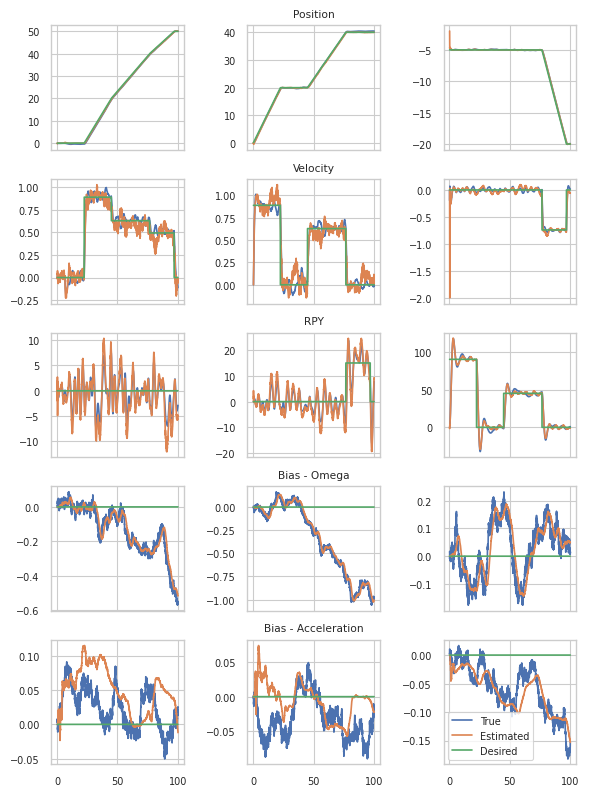

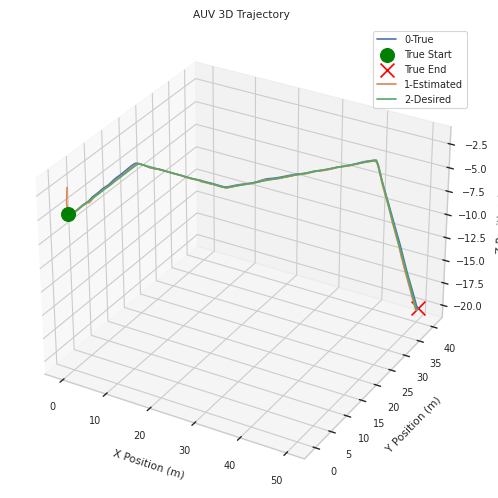

Plot updated in Jupyter Notebook.


In [4]:
main(num_seconds=100, show=False, plot=True, verbose=False,route="aco")

this Dijkstra way


100%|████████████████████████████████████| 10000/10000 [00:40<00:00, 247.68it/s]


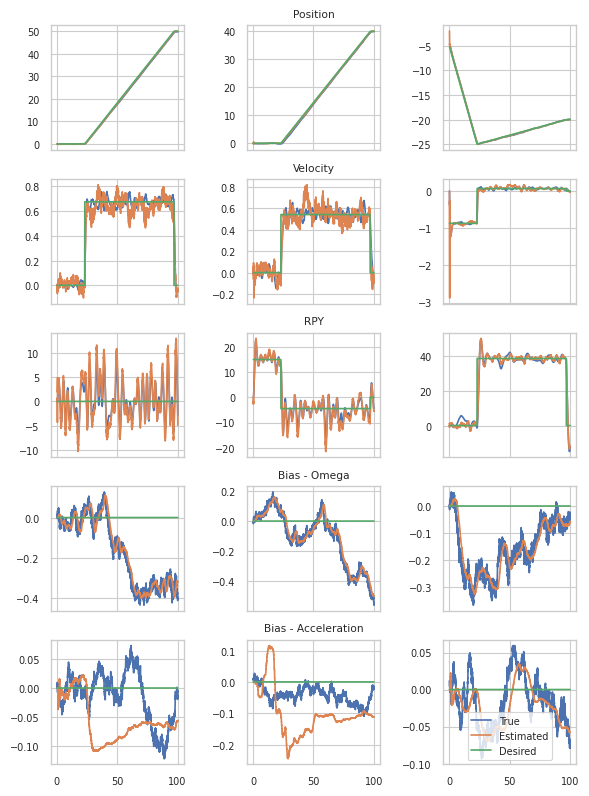

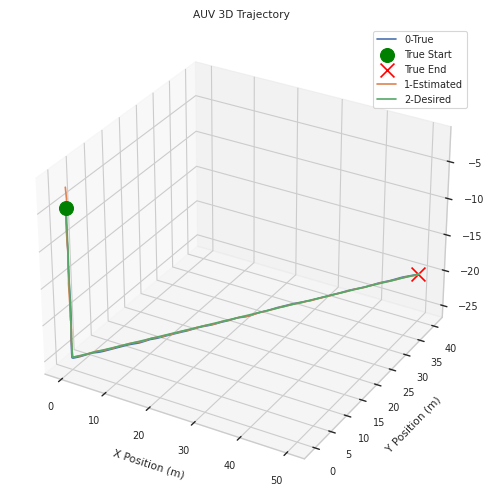

Plot updated in Jupyter Notebook.


In [4]:
main(num_seconds=100, show=False, plot=True, verbose=False,route="djs")

In [4]:
main(num_seconds=100, show=False, plot=True, verbose=False,route="astar")

KeyboardInterrupt: 

this RRT way


100%|████████████████████████████████████| 10000/10000 [00:39<00:00, 250.83it/s]


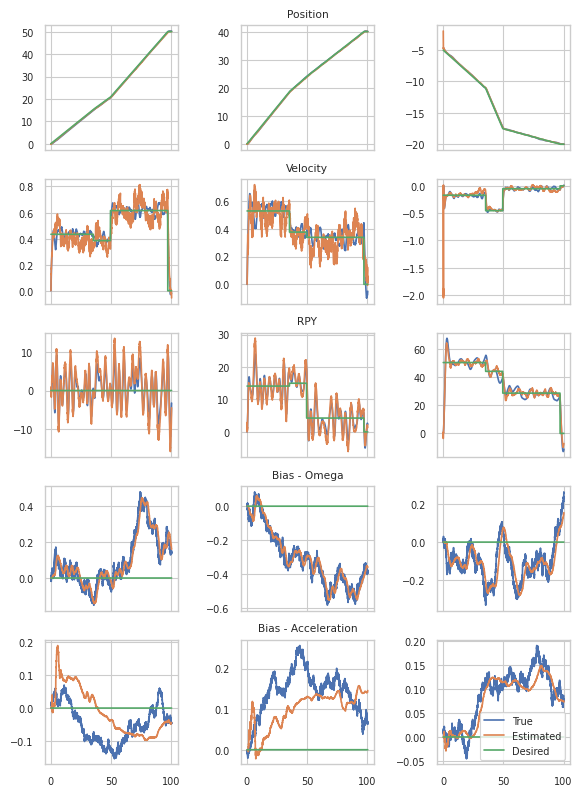

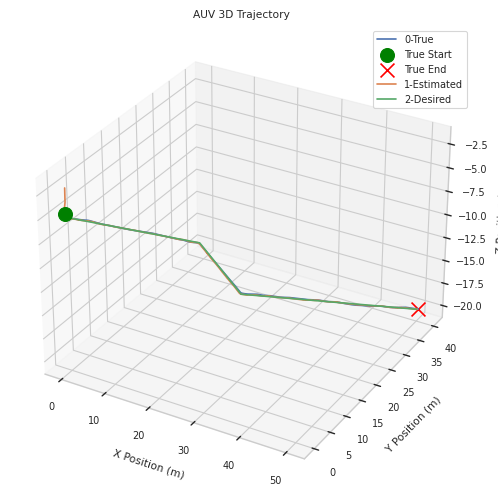

Plot updated in Jupyter Notebook.


In [5]:
main(num_seconds=100, show=False, plot=True, verbose=False,route="rrt")